In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
#AAPL
# Load the data from the Data folder
data_folder = 'Data'
file_name = 'AAPL_processed_data.csv'
file_path = data_folder + "/" + file_name

aapl_df = pd.read_csv(file_path, parse_dates=['Date'])

#print(aapl_df.shape)
#aapl_df.head()

# Handle missing values by dropping rows with NaN
aapl_df = aapl_df.dropna()

# Select all features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', '5_day_SMA', '20_day_SMA', '50_day_SMA',
            '14_day_RSI', 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return', 'Volatility']
aapl_X = aapl_df[features]
aapl_y = aapl_df['Close']  # Target variable: the 'Close' price

# Shift the features to align with the target variable
aapl_X = aapl_X.shift(1)  # Shift features down by 1 to make day t-1 correspond to day t
aapl_y = aapl_y[1:]  # The target starts from the second entry (day t)

# Drop the first row as it will contain NaN values due to shifting
aapl_X = aapl_X.dropna()
aapl_y = aapl_y.dropna()

aapl_df = aapl_df.iloc[1:]  # Drop the first row of the original DataFrame
aapl_dates = aapl_df['Date']  # Get the adjusted dates

# Now drop the dates that correspond to the remaining data
aapl_dates = aapl_dates.dropna()  # Ensure dates match the new X and y

# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
aapl_X_scaled = scaler.fit_transform(aapl_X)

aapl_X_scaled = aapl_X_scaled.reshape((aapl_X_scaled.shape[0], aapl_X_scaled.shape[1], 1))  # Reshape for 1D CNN

aapl_y_scaled = scaler.fit_transform(aapl_y.values.reshape(-1, 1))

# Split the data in time sequence (80% training, 20% testing)
aapl_split_index = int(len(aapl_X_scaled) * 0.8)  # Calculate the index for the 80-20 split

aapl_X_train = aapl_X_scaled[:aapl_split_index]
aapl_X_test = aapl_X_scaled[aapl_split_index:]
aapl_y_train = aapl_y_scaled[:aapl_split_index]
aapl_y_test = aapl_y_scaled[aapl_split_index:]
aapl_dates_train = aapl_dates[:aapl_split_index]
aapl_dates_test = aapl_dates[aapl_split_index:]

# Extract corresponding dates for test set (if needed for plotting later)
aapl_test_dates = aapl_df['Date'].values[aapl_split_index:]

#print(f"X_train shape: {aapl_X_train.shape}")  # Should be (samples, features, 1)
#print(f"X_test shape: {aapl_X_test.shape}")
#print(f"y_train shape: {aapl_X_train.shape}")  # Should be (samples, features, 1)
#print(f"y_test shape: {aapl_X_test.shape}")

# Define the CNN model with Dropout
aapl_model = Sequential()

# 1D Convolutional layer
aapl_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(features), 1)))
aapl_model.add(MaxPooling1D(pool_size=2))

# Add Dropout after Conv layer to prevent overfitting
aapl_model.add(Dropout(0.3))  # Dropout 30% of the units

# Flatten the 1D output to feed into dense layers
aapl_model.add(Flatten())

# Fully connected layer
aapl_model.add(Dense(50, activation='relu'))

# Add Dropout after the Dense layer
aapl_model.add(Dropout(0.3))  # Dropout 30% of the units

# Output layer (1 neuron for predicting the 'Close' price)
aapl_model.add(Dense(1))

# Compile the model
aapl_model.compile(optimizer='adam', loss='mse')

# Model summary
aapl_model.summary()

# Train the model
aapl_model.fit(aapl_X_train, aapl_y_train, epochs=60, batch_size=32, validation_data=(aapl_X_test, aapl_y_test))

# Evaluate the model
aapl_test_loss = aapl_model.evaluate(aapl_X_test, aapl_y_test)
print(f'Test Loss: {aapl_test_loss}')

# After model predictions
aapl_cnn_predicted_prices = aapl_model.predict(aapl_X_test)

# Convert y_test to a NumPy array before flattening
aapl_y_test = np.array(aapl_y_test)

# Inverse transformation for predicted prices
aapl_cnn_predicted_prices_reshaped = np.zeros((aapl_cnn_predicted_prices.shape[0], aapl_X.shape[1]))  # Create a 2D array with the same number of features
aapl_cnn_predicted_prices_reshaped[:, 3] = aapl_cnn_predicted_prices.flatten()  # Fill the 'Close' column (index 3)

# Inverse transform to get back the original prices
aapl_cnn_predicted_prices_inverse = scaler.inverse_transform(aapl_cnn_predicted_prices_reshaped)[:, 3]  # Extract only the 'Close' prices after inverse transform

# Inverse transformation for actual prices
aapl_cnn_ytest_reshaped = np.zeros((aapl_y_test.shape[0], aapl_X.shape[1]))  # Create a 2D array for actual values
aapl_cnn_ytest_reshaped[:, 3] = aapl_y_test.flatten()  # Fill the 'Close' column

# Inverse scale to get the actual 'Close' values
aapl_cnn_actual_prices_inverse = scaler.inverse_transform(aapl_cnn_ytest_reshaped)[:, 3]  # Extract only the 'Close' prices

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,493 (76.14 KB)

 Trainable params: 19,493 (76.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0192 - val_loss: 8.1902e-04
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 3.5691e-04
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 8.6878e-04
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 6.2835e-04
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 4.5826e-04
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 3.5850e-04
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 6.9927e-04
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 7.3730e-04
Epoch 10/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 11/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 12/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [4]:
# Calculate RMSE and MAE
aapl_rmse = np.sqrt(mean_squared_error(aapl_cnn_actual_prices_inverse, aapl_cnn_predicted_prices_inverse))
aapl_mae = mean_absolute_error(aapl_cnn_actual_prices_inverse, aapl_cnn_predicted_prices_inverse)

print(f'RMSE: {aapl_rmse}')
print(f'MAE: {aapl_mae}')

RMSE: 3.30613727728881
MAE: 2.4854312248407684


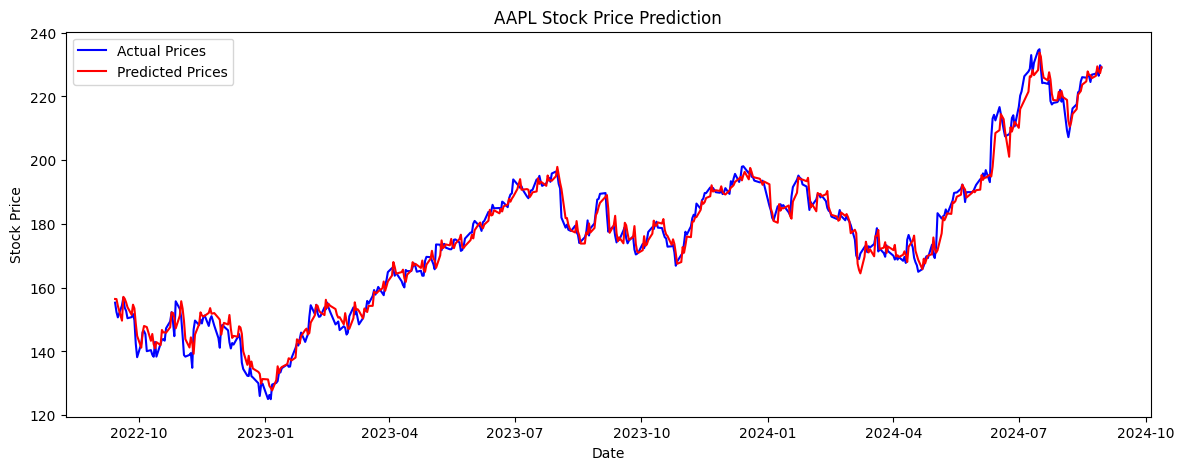

In [5]:
#Plot
plt.figure(figsize=(14, 5))
plt.plot(aapl_dates_test, aapl_cnn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(aapl_dates_test, aapl_cnn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

In [6]:
#AMZN
# Load the data from the Data folder
data_folder = 'Data'
file_name = 'AMZN_processed_data.csv'
file_path = data_folder + "/" + file_name


amzn_df = pd.read_csv(file_path, parse_dates=['Date'])


#print(amzn_df.shape)
#amzn_df.head()


# Handle missing values by dropping rows with NaN
amzn_df = amzn_df.dropna()


# Select all features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', '5_day_SMA', '20_day_SMA', '50_day_SMA',
            '14_day_RSI', 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return', 'Volatility']
amzn_X = amzn_df[features]
amzn_y = amzn_df['Close']  # Target variable: the 'Close' price


# Shift the features to align with the target variable
amzn_X = amzn_X.shift(1)  # Shift features down by 1 to make day t-1 correspond to day t
amzn_y = amzn_y[1:]  # The target starts from the second entry (day t)


# Drop the first row as it will contain NaN values due to shifting
amzn_X = amzn_X.dropna()
amzn_y = amzn_y.dropna()


amzn_df = amzn_df.iloc[1:]  # Drop the first row of the original DataFrame
amzn_dates = amzn_df['Date']  # Get the adjusted dates


# Now drop the dates that correspond to the remaining data
amzn_dates = amzn_dates.dropna()  # Ensure dates match the new X and y


# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
amzn_X_scaled = scaler.fit_transform(amzn_X)


amzn_X_scaled = amzn_X_scaled.reshape((amzn_X_scaled.shape[0], amzn_X_scaled.shape[1], 1))  # Reshape for 1D CNN


amzn_y_scaled = scaler.fit_transform(amzn_y.values.reshape(-1, 1))


# Split the data in time sequence (80% training, 20% testing)
amzn_split_index = int(len(amzn_X_scaled) * 0.8)  # Calculate the index for the 80-20 split


amzn_X_train = amzn_X_scaled[:amzn_split_index]
amzn_X_test = amzn_X_scaled[amzn_split_index:]
amzn_y_train = amzn_y_scaled[:amzn_split_index]
amzn_y_test = amzn_y_scaled[amzn_split_index:]
amzn_dates_train = amzn_dates[:amzn_split_index]
amzn_dates_test = amzn_dates[amzn_split_index:]


# Extract corresponding dates for test set (if needed for plotting later)
amzn_test_dates = amzn_df['Date'].values[amzn_split_index:]


#print(f"X_train shape: {amzn_X_train.shape}")  # Should be (samples, features, 1)
#print(f"X_test shape: {amzn_X_test.shape}")
#print(f"y_train shape: {amzn_X_train.shape}")  # Should be (samples, features, 1)
#print(f"y_test shape: {amzn_X_test.shape}")


# Define the CNN model with Dropout
amzn_model = Sequential()


# 1D Convolutional layer
amzn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(features), 1)))
amzn_model.add(MaxPooling1D(pool_size=2))


# Add Dropout after Conv layer to prevent overfitting
amzn_model.add(Dropout(0.3))  # Dropout 30% of the units


# Flatten the 1D output to feed into dense layers
amzn_model.add(Flatten())


# Fully connected layer
amzn_model.add(Dense(50, activation='relu'))


# Add Dropout after the Dense layer
amzn_model.add(Dropout(0.3))  # Dropout 30% of the units


# Output layer (1 neuron for predicting the 'Close' price)
amzn_model.add(Dense(1))


# Compile the model
amzn_model.compile(optimizer='adam', loss='mse')


# Model summary
amzn_model.summary()


# Train the model
amzn_model.fit(amzn_X_train, amzn_y_train, epochs=60, batch_size=32, validation_data=(amzn_X_test, amzn_y_test))


# Evaluate the model
amzn_test_loss = amzn_model.evaluate(amzn_X_test, amzn_y_test)
print(f'Test Loss: {amzn_test_loss}')


# After model predictions
amzn_cnn_predicted_prices = amzn_model.predict(amzn_X_test)


# Convert y_test to a NumPy array before flattening
amzn_y_test = np.array(amzn_y_test)


# Inverse transformation for predicted prices
amzn_cnn_predicted_prices_reshaped = np.zeros((amzn_cnn_predicted_prices.shape[0], amzn_X.shape[1]))  # Create a 2D array with the same number of features
amzn_cnn_predicted_prices_reshaped[:, 3] = amzn_cnn_predicted_prices.flatten()  # Fill the 'Close' column (index 3)


# Inverse transform to get back the original prices
amzn_cnn_predicted_prices_inverse = scaler.inverse_transform(amzn_cnn_predicted_prices_reshaped)[:, 3]  # Extract only the 'Close' prices after inverse transform


# Inverse transformation for actual prices
amzn_cnn_ytest_reshaped = np.zeros((amzn_y_test.shape[0], amzn_X.shape[1]))  # Create a 2D array for actual values
amzn_cnn_ytest_reshaped[:, 3] = amzn_y_test.flatten()  # Fill the 'Close' column


# Inverse scale to get the actual 'Close' values
amzn_cnn_actual_prices_inverse = scaler.inverse_transform(amzn_cnn_ytest_reshaped)[:, 3]  # Extract only the 'Close' prices

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,493 (76.14 KB)

 Trainable params: 19,493 (76.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0572 - val_loss: 0.0013
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 8.6290e-04
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 8.9093e-04
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 8.9190e-04
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 3.8383e-04
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 4.9893e-04
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 10/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 3.2922e-04
Epoch 11/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 12/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [7]:
# Calculate RMSE and MAE
amzn_rmse = np.sqrt(mean_squared_error(amzn_cnn_actual_prices_inverse, amzn_cnn_predicted_prices_inverse))
amzn_mae = mean_absolute_error(amzn_cnn_actual_prices_inverse, amzn_cnn_predicted_prices_inverse)


print(f'RMSE: {amzn_rmse}')
print(f'MAE: {amzn_mae}')


RMSE: 4.378723740244086
MAE: 3.5847570853161037


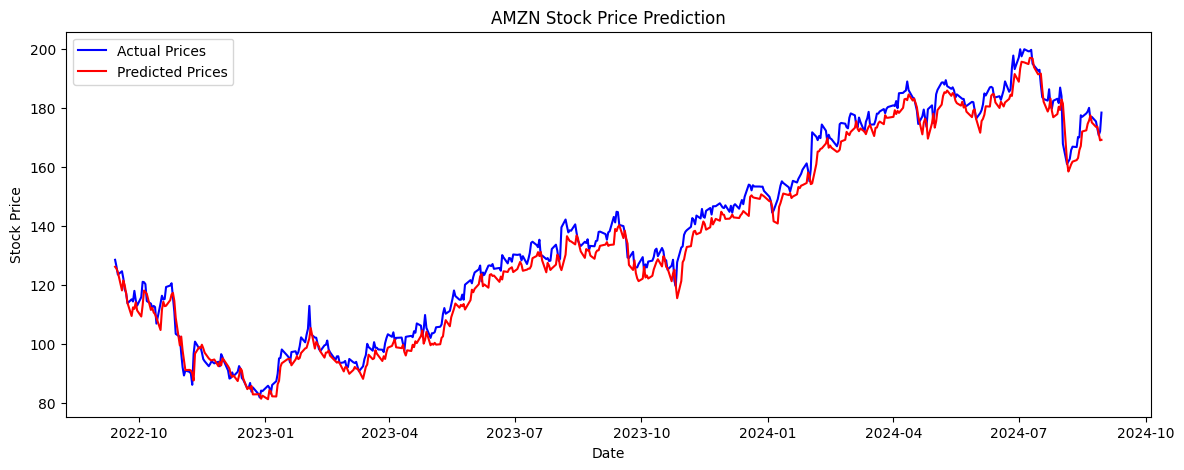

In [8]:
#Plot
plt.figure(figsize=(14, 5))
plt.plot(amzn_dates_test, amzn_cnn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(amzn_dates_test, amzn_cnn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()

In [9]:
# Load the data from the Data folder
data_folder = 'Data'
file_name = 'GOOG_processed_data.csv'
file_path = data_folder + "/" + file_name


goog_df = pd.read_csv(file_path, parse_dates=['Date'])


#print(goog_df.shape)
#goog_df.head()


# Handle missing values by dropping rows with NaN
goog_df = goog_df.dropna()


# Select all features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', '5_day_SMA', '20_day_SMA', '50_day_SMA',
            '14_day_RSI', 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return', 'Volatility']
goog_X = goog_df[features]
goog_y = goog_df['Close']  # Target variable: the 'Close' price


# Shift the features to align with the target variable
goog_X = goog_X.shift(1)  # Shift features down by 1 to make day t-1 correspond to day t
goog_y = goog_y[1:]  # The target starts from the second entry (day t)


# Drop the first row as it will contain NaN values due to shifting
goog_X = goog_X.dropna()
goog_y = goog_y.dropna()


goog_df = goog_df.iloc[1:]  # Drop the first row of the original DataFrame
goog_dates = goog_df['Date']  # Get the adjusted dates


# Now drop the dates that correspond to the remaining data
goog_dates = goog_dates.dropna()  # Ensure dates match the new X and y


# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
goog_X_scaled = scaler.fit_transform(goog_X)


goog_X_scaled = goog_X_scaled.reshape((goog_X_scaled.shape[0], goog_X_scaled.shape[1], 1))  # Reshape for 1D CNN


goog_y_scaled = scaler.fit_transform(goog_y.values.reshape(-1, 1))


# Split the data in time sequence (80% training, 20% testing)
goog_split_index = int(len(goog_X_scaled) * 0.8)  # Calculate the index for the 80-20 split


goog_X_train = goog_X_scaled[:goog_split_index]
goog_X_test = goog_X_scaled[goog_split_index:]
goog_y_train = goog_y_scaled[:goog_split_index]
goog_y_test = goog_y_scaled[goog_split_index:]
goog_dates_train = goog_dates[:goog_split_index]
goog_dates_test = goog_dates[goog_split_index:]


# Extract corresponding dates for test set (if needed for plotting later)
goog_test_dates = goog_df['Date'].values[goog_split_index:]


#print(f"X_train shape: {goog_X_train.shape}")  # Should be (samples, features, 1)
#print(f"X_test shape: {goog_X_test.shape}")
#print(f"y_train shape: {goog_X_train.shape}")  # Should be (samples, features, 1)
#print(f"y_test shape: {goog_X_test.shape}")


# Define the CNN model with Dropout
goog_model = Sequential()


# 1D Convolutional layer
goog_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(features), 1)))
goog_model.add(MaxPooling1D(pool_size=2))


# Add Dropout after Conv layer to prevent overfitting
goog_model.add(Dropout(0.3))  # Dropout 30% of the units


# Flatten the 1D output to feed into dense layers
goog_model.add(Flatten())


# Fully connected layer
goog_model.add(Dense(50, activation='relu'))


# Add Dropout after the Dense layer
goog_model.add(Dropout(0.3))  # Dropout 30% of the units


# Output layer (1 neuron for predicting the 'Close' price)
goog_model.add(Dense(1))


# Compile the model
goog_model.compile(optimizer='adam', loss='mse')


# Model summary
goog_model.summary()


# Train the model
goog_model.fit(goog_X_train, goog_y_train, epochs=60, batch_size=32, validation_data=(goog_X_test, goog_y_test))


# Evaluate the model
goog_test_loss = goog_model.evaluate(goog_X_test, goog_y_test)
print(f'Test Loss: {goog_test_loss}')


# After model predictions
goog_cnn_predicted_prices = goog_model.predict(goog_X_test)


# Convert y_test to a NumPy array before flattening
goog_y_test = np.array(goog_y_test)


# Inverse transformation for predicted prices
goog_cnn_predicted_prices_reshaped = np.zeros((goog_cnn_predicted_prices.shape[0], goog_X.shape[1]))  # Create a 2D array with the same number of features
goog_cnn_predicted_prices_reshaped[:, 3] = goog_cnn_predicted_prices.flatten()  # Fill the 'Close' column (index 3)


# Inverse transform to get back the original prices
goog_cnn_predicted_prices_inverse = scaler.inverse_transform(goog_cnn_predicted_prices_reshaped)[:, 3]  # Extract only the 'Close' prices after inverse transform


# Inverse transformation for actual prices
goog_cnn_ytest_reshaped = np.zeros((goog_y_test.shape[0], goog_X.shape[1]))  # Create a 2D array for actual values
goog_cnn_ytest_reshaped[:, 3] = goog_y_test.flatten()  # Fill the 'Close' column


# Inverse scale to get the actual 'Close' values
goog_cnn_actual_prices_inverse = scaler.inverse_transform(goog_cnn_ytest_reshaped)[:, 3]  # Extract only the 'Close' prices


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,493 (76.14 KB)

 Trainable params: 19,493 (76.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0239 - val_loss: 0.0024
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 5.2418e-04
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 3.3739e-04
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 3.4757e-04
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 4.3131e-04
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 10/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 11/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 3.6221e-04
Epoch 12/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

In [10]:
# Calculate RMSE and MAE
goog_rmse = np.sqrt(mean_squared_error(goog_cnn_actual_prices_inverse, goog_cnn_predicted_prices_inverse))
goog_mae = mean_absolute_error(goog_cnn_actual_prices_inverse, goog_cnn_predicted_prices_inverse)


print(f'RMSE: {goog_rmse}')
print(f'MAE: {goog_mae}')

RMSE: 4.550921260522264
MAE: 3.841391616362298


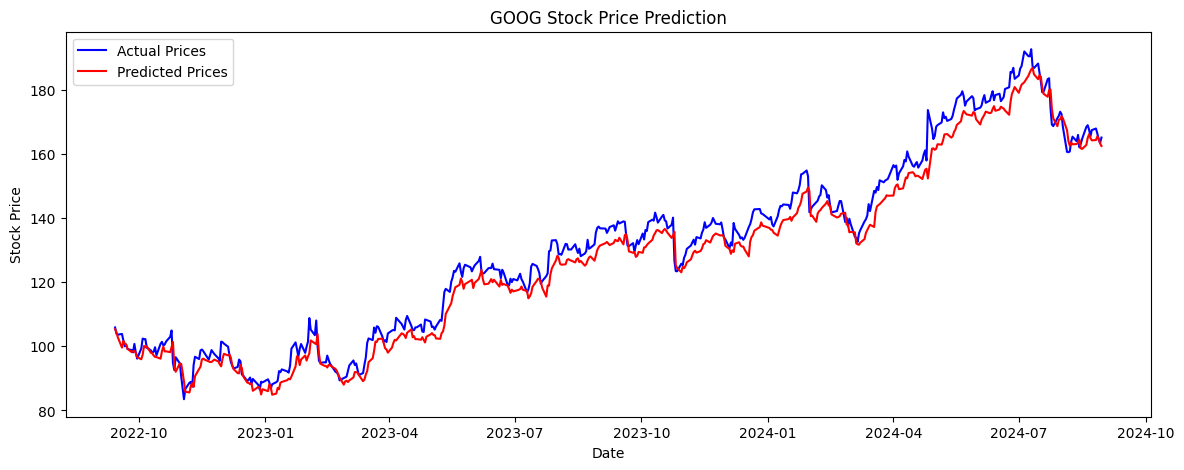

In [11]:
#Plot
plt.figure(figsize=(14, 5))
plt.plot(goog_dates_test, goog_cnn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(goog_dates_test, goog_cnn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('GOOG Stock Price Prediction')
plt.legend()
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,493 (76.14 KB)

 Trainable params: 19,493 (76.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - val_loss: 0.0041
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 8.9790e-04
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 6.8159e-04
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 7.2232e-04
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 8.0217e-04
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 9.1832e-04
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 5.1464e-04
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 7.5916e-04
Epoch 10/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 5.8313e-04
Epoch 11/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 7.8149e-04
Epoch 12/60
62/62 ━━━━━━━━━━━━━━━━━━━━

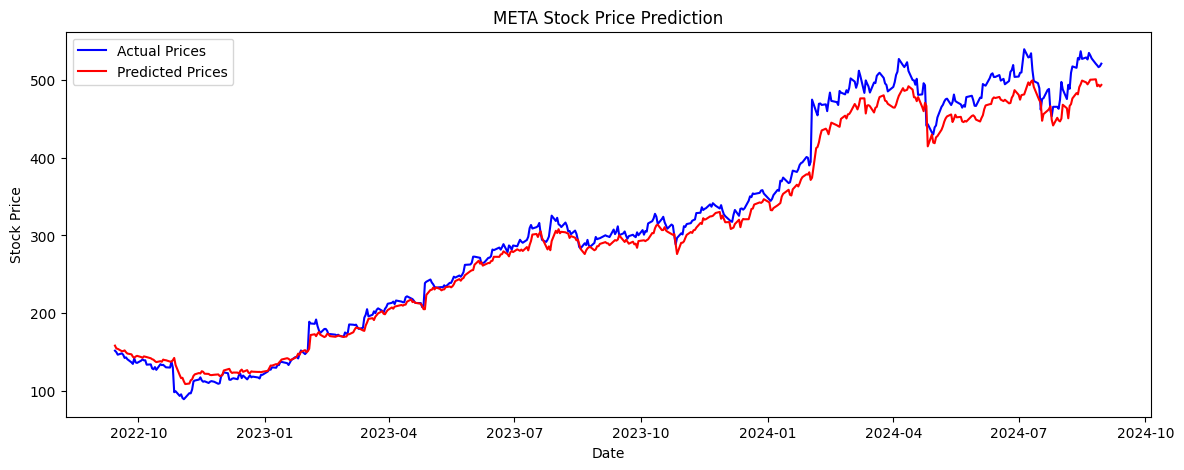

In [12]:
# Load the data from the Data folder
data_folder = 'Data'
file_name = 'META_processed_data.csv'
file_path = data_folder + "/" + file_name


meta_df = pd.read_csv(file_path, parse_dates=['Date'])


#print(meta_df.shape)
#meta_df.head()


# Handle missing values by dropping rows with NaN
meta_df = meta_df.dropna()


# Select all features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', '5_day_SMA', '20_day_SMA', '50_day_SMA',
            '14_day_RSI', 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return', 'Volatility']
meta_X = meta_df[features]
meta_y = meta_df['Close']  # Target variable: the 'Close' price


# Shift the features to align with the target variable
meta_X = meta_X.shift(1)  # Shift features down by 1 to make day t-1 correspond to day t
meta_y = meta_y[1:]  # The target starts from the second entry (day t)


# Drop the first row as it will contain NaN values due to shifting
meta_X = meta_X.dropna()
meta_y = meta_y.dropna()


meta_df = meta_df.iloc[1:]  # Drop the first row of the original DataFrame
meta_dates = meta_df['Date']  # Get the adjusted dates


# Now drop the dates that correspond to the remaining data
meta_dates = meta_dates.dropna()  # Ensure dates match the new X and y


# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
meta_X_scaled = scaler.fit_transform(meta_X)


meta_X_scaled = meta_X_scaled.reshape((meta_X_scaled.shape[0], meta_X_scaled.shape[1], 1))  # Reshape for 1D CNN


meta_y_scaled = scaler.fit_transform(meta_y.values.reshape(-1, 1))


# Split the data in time sequence (80% training, 20% testing)
meta_split_index = int(len(meta_X_scaled) * 0.8)  # Calculate the index for the 80-20 split


meta_X_train = meta_X_scaled[:meta_split_index]
meta_X_test = meta_X_scaled[meta_split_index:]
meta_y_train = meta_y_scaled[:meta_split_index]
meta_y_test = meta_y_scaled[meta_split_index:]
meta_dates_train = meta_dates[:meta_split_index]
meta_dates_test = meta_dates[meta_split_index:]


# Extract corresponding dates for test set (if needed for plotting later)
meta_test_dates = meta_df['Date'].values[meta_split_index:]


#print(f"X_train shape: {meta_X_train.shape}")  # Should be (samples, features, 1)
#print(f"X_test shape: {meta_X_test.shape}")
#print(f"y_train shape: {meta_X_train.shape}")  # Should be (samples, features, 1)
#print(f"y_test shape: {meta_X_test.shape}")


# Define the CNN model with Dropout
meta_model = Sequential()


# 1D Convolutional layer
meta_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(features), 1)))
meta_model.add(MaxPooling1D(pool_size=2))


# Add Dropout after Conv layer to prevent overfitting
meta_model.add(Dropout(0.3))  # Dropout 30% of the units


# Flatten the 1D output to feed into dense layers
meta_model.add(Flatten())


# Fully connected layer
meta_model.add(Dense(50, activation='relu'))


# Add Dropout after the Dense layer
meta_model.add(Dropout(0.3))  # Dropout 30% of the units


# Output layer (1 neuron for predicting the 'Close' price)
meta_model.add(Dense(1))


# Compile the model
meta_model.compile(optimizer='adam', loss='mse')


# Model summary
meta_model.summary()


# Train the model
meta_model.fit(meta_X_train, meta_y_train, epochs=60, batch_size=32, validation_data=(meta_X_test, meta_y_test))


# Evaluate the model
meta_test_loss = meta_model.evaluate(meta_X_test, meta_y_test)
print(f'Test Loss: {meta_test_loss}')


# After model predictions
meta_cnn_predicted_prices = meta_model.predict(meta_X_test)


# Convert y_test to a NumPy array before flattening
meta_y_test = np.array(meta_y_test)


# Inverse transformation for predicted prices
meta_cnn_predicted_prices_reshaped = np.zeros((meta_cnn_predicted_prices.shape[0], meta_X.shape[1]))  # Create a 2D array with the same number of features
meta_cnn_predicted_prices_reshaped[:, 3] = meta_cnn_predicted_prices.flatten()  # Fill the 'Close' column (index 3)


# Inverse transform to get back the original prices
meta_cnn_predicted_prices_inverse = scaler.inverse_transform(meta_cnn_predicted_prices_reshaped)[:, 3]  # Extract only the 'Close' prices after inverse transform


# Inverse transformation for actual prices
meta_cnn_ytest_reshaped = np.zeros((meta_y_test.shape[0], meta_X.shape[1]))  # Create a 2D array for actual values
meta_cnn_ytest_reshaped[:, 3] = meta_y_test.flatten()  # Fill the 'Close' column


# Inverse scale to get the actual 'Close' values
meta_cnn_actual_prices_inverse = scaler.inverse_transform(meta_cnn_ytest_reshaped)[:, 3]  # Extract only the 'Close' prices


# Calculate RMSE and MAE
meta_rmse = np.sqrt(mean_squared_error(meta_cnn_actual_prices_inverse, meta_cnn_predicted_prices_inverse))
meta_mae = mean_absolute_error(meta_cnn_actual_prices_inverse, meta_cnn_predicted_prices_inverse)


print(f'RMSE: {meta_rmse}')
print(f'MAE: {meta_mae}')


#Plot
plt.figure(figsize=(14, 5))
plt.plot(meta_dates_test, meta_cnn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(meta_dates_test, meta_cnn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('META Stock Price Prediction')
plt.legend()
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,493 (76.14 KB)

 Trainable params: 19,493 (76.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0267 - val_loss: 7.7569e-04
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 2.5435e-04
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 5.9343e-04
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 8.5533e-04
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 3.3261e-04
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 2.8158e-04
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 9.7028e-04
Epoch 10/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 6.1957e-04
Epoch 12/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 

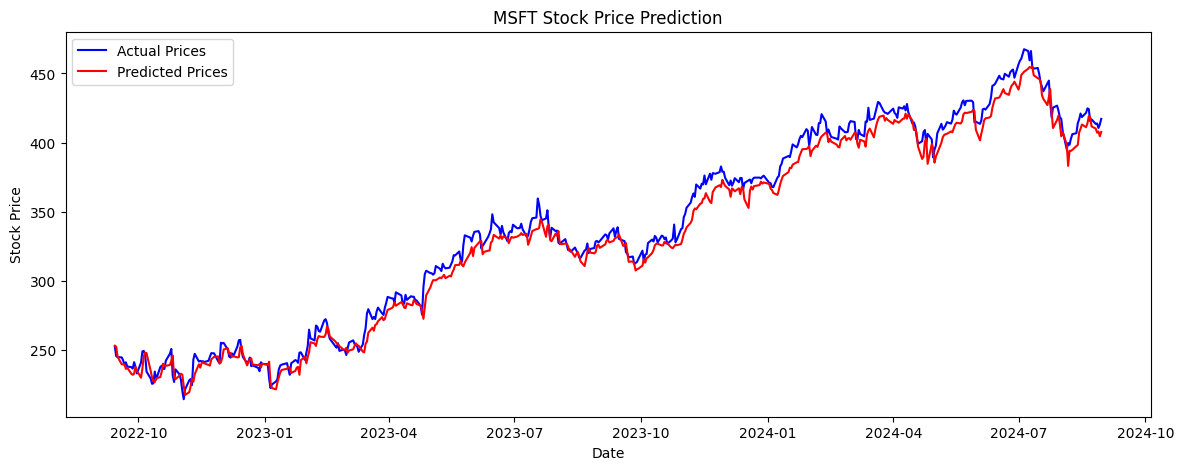

In [13]:
# Load the data from the Data folder
data_folder = 'Data'
file_name = 'MSFT_processed_data.csv'
file_path = data_folder + "/" + file_name


msft_df = pd.read_csv(file_path, parse_dates=['Date'])


#print(msft_df.shape)
#msft_df.head()


# Handle missing values by dropping rows with NaN
msft_df = msft_df.dropna()


# Select all features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', '5_day_SMA', '20_day_SMA', '50_day_SMA',
            '14_day_RSI', 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return', 'Volatility']
msft_X = msft_df[features]
msft_y = msft_df['Close']  # Target variable: the 'Close' price


# Shift the features to align with the target variable
msft_X = msft_X.shift(1)  # Shift features down by 1 to make day t-1 correspond to day t
msft_y = msft_y[1:]  # The target starts from the second entry (day t)


# Drop the first row as it will contain NaN values due to shifting
msft_X = msft_X.dropna()
msft_y = msft_y.dropna()


msft_df = msft_df.iloc[1:]  # Drop the first row of the original DataFrame
msft_dates = msft_df['Date']  # Get the adjusted dates


# Now drop the dates that correspond to the remaining data
msft_dates = msft_dates.dropna()  # Ensure dates match the new X and y


# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
msft_X_scaled = scaler.fit_transform(msft_X)


msft_X_scaled = msft_X_scaled.reshape((msft_X_scaled.shape[0], msft_X_scaled.shape[1], 1))  # Reshape for 1D CNN


msft_y_scaled = scaler.fit_transform(msft_y.values.reshape(-1, 1))


# Split the data in time sequence (80% training, 20% testing)
msft_split_index = int(len(msft_X_scaled) * 0.8)  # Calculate the index for the 80-20 split


msft_X_train = msft_X_scaled[:msft_split_index]
msft_X_test = msft_X_scaled[msft_split_index:]
msft_y_train = msft_y_scaled[:msft_split_index]
msft_y_test = msft_y_scaled[msft_split_index:]
msft_dates_train = msft_dates[:msft_split_index]
msft_dates_test = msft_dates[msft_split_index:]


# Extract corresponding dates for test set (if needed for plotting later)
msft_test_dates = msft_df['Date'].values[msft_split_index:]


#print(f"X_train shape: {msft_X_train.shape}")  # Should be (samples, features, 1)
#print(f"X_test shape: {msft_X_test.shape}")
#print(f"y_train shape: {msft_X_train.shape}")  # Should be (samples, features, 1)
#print(f"y_test shape: {msft_X_test.shape}")


# Define the CNN model with Dropout
msft_model = Sequential()


# 1D Convolutional layer
msft_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(features), 1)))
msft_model.add(MaxPooling1D(pool_size=2))


# Add Dropout after Conv layer to prevent overfitting
msft_model.add(Dropout(0.3))  # Dropout 30% of the units


# Flatten the 1D output to feed into dense layers
msft_model.add(Flatten())


# Fully connected layer
msft_model.add(Dense(50, activation='relu'))


# Add Dropout after the Dense layer
msft_model.add(Dropout(0.3))  # Dropout 30% of the units


# Output layer (1 neuron for predicting the 'Close' price)
msft_model.add(Dense(1))


# Compile the model
msft_model.compile(optimizer='adam', loss='mse')


# Model summary
msft_model.summary()


# Train the model
msft_model.fit(msft_X_train, msft_y_train, epochs=60, batch_size=32, validation_data=(msft_X_test, msft_y_test))


# Evaluate the model
msft_test_loss = msft_model.evaluate(msft_X_test, msft_y_test)
print(f'Test Loss: {msft_test_loss}')


# After model predictions
msft_cnn_predicted_prices = msft_model.predict(msft_X_test)


# Convert y_test to a NumPy array before flattening
msft_y_test = np.array(msft_y_test)


# Inverse transformation for predicted prices
msft_cnn_predicted_prices_reshaped = np.zeros((msft_cnn_predicted_prices.shape[0], msft_X.shape[1]))  # Create a 2D array with the same number of features
msft_cnn_predicted_prices_reshaped[:, 3] = msft_cnn_predicted_prices.flatten()  # Fill the 'Close' column (index 3)


# Inverse transform to get back the original prices
msft_cnn_predicted_prices_inverse = scaler.inverse_transform(msft_cnn_predicted_prices_reshaped)[:, 3]  # Extract only the 'Close' prices after inverse transform


# Inverse transformation for actual prices
msft_cnn_ytest_reshaped = np.zeros((msft_y_test.shape[0], msft_X.shape[1]))  # Create a 2D array for actual values
msft_cnn_ytest_reshaped[:, 3] = msft_y_test.flatten()  # Fill the 'Close' column


# Inverse scale to get the actual 'Close' values
msft_cnn_actual_prices_inverse = scaler.inverse_transform(msft_cnn_ytest_reshaped)[:, 3]  # Extract only the 'Close' prices


# Calculate RMSE and MAE
msft_rmse = np.sqrt(mean_squared_error(msft_cnn_actual_prices_inverse, msft_cnn_predicted_prices_inverse))
msft_mae = mean_absolute_error(msft_cnn_actual_prices_inverse, msft_cnn_predicted_prices_inverse)


print(f'RMSE: {msft_rmse}')
print(f'MAE: {msft_mae}')


#Plot
plt.figure(figsize=(14, 5))
plt.plot(msft_dates_test, msft_cnn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(msft_dates_test, msft_cnn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.legend()
plt.show()





c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,493 (76.14 KB)

 Trainable params: 19,493 (76.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2285e-04 - val_loss: 0.0032
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1651e-04 - val_loss: 6.9918e-04
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0295e-04 - val_loss: 8.2305e-04
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9769e-04 - val_loss: 6.6585e-04
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3198e-04 - val_loss: 0.0011
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5525e-04 - val_loss: 8.6613e-04
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0001e-04 - val_loss: 0.0012
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3304e-04 - val_loss: 5.4491e-04
Epoch 10/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2584e-04 - val_loss: 6.3521e-04
Epoch 11/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4952e-04 - val_loss: 0.0017
Epoch 12/6

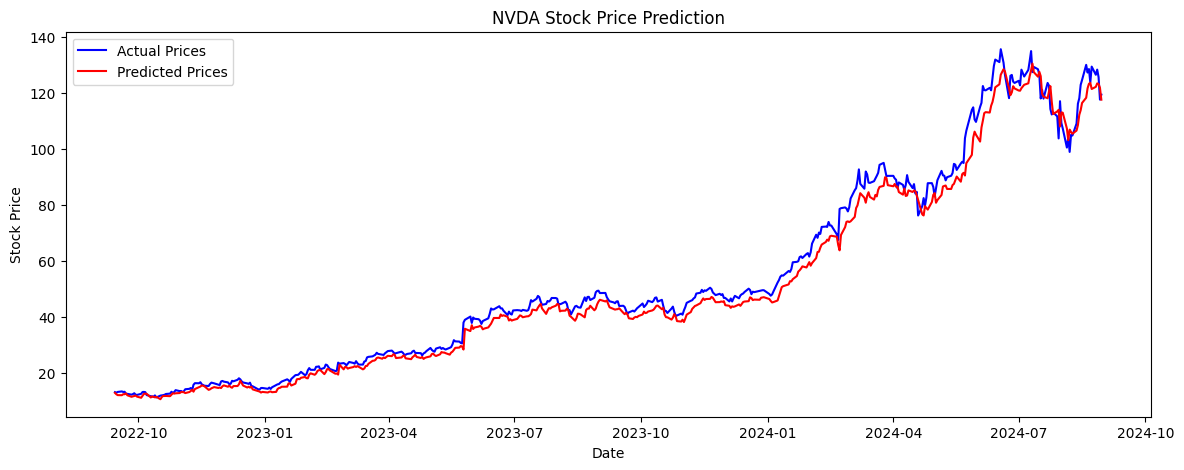

In [14]:
# Load the data from the Data folder
data_folder = 'Data'
file_name = 'NVDA_processed_data.csv'
file_path = data_folder + "/" + file_name


nvda_df = pd.read_csv(file_path, parse_dates=['Date'])


#print(nvda_df.shape)
#nvda_df.head()


# Handle missing values by dropping rows with NaN
nvda_df = nvda_df.dropna()


# Select all features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', '5_day_SMA', '20_day_SMA', '50_day_SMA',
            '14_day_RSI', 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return', 'Volatility']
nvda_X = nvda_df[features]
nvda_y = nvda_df['Close']  # Target variable: the 'Close' price


# Shift the features to align with the target variable
nvda_X = nvda_X.shift(1)  # Shift features down by 1 to make day t-1 correspond to day t
nvda_y = nvda_y[1:]  # The target starts from the second entry (day t)


# Drop the first row as it will contain NaN values due to shifting
nvda_X = nvda_X.dropna()
nvda_y = nvda_y.dropna()


nvda_df = nvda_df.iloc[1:]  # Drop the first row of the original DataFrame
nvda_dates = nvda_df['Date']  # Get the adjusted dates


# Now drop the dates that correspond to the remaining data
nvda_dates = nvda_dates.dropna()  # Ensure dates match the new X and y


# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
nvda_X_scaled = scaler.fit_transform(nvda_X)


nvda_X_scaled = nvda_X_scaled.reshape((nvda_X_scaled.shape[0], nvda_X_scaled.shape[1], 1))  # Reshape for 1D CNN


nvda_y_scaled = scaler.fit_transform(nvda_y.values.reshape(-1, 1))


# Split the data in time sequence (80% training, 20% testing)
nvda_split_index = int(len(nvda_X_scaled) * 0.8)  # Calculate the index for the 80-20 split


nvda_X_train = nvda_X_scaled[:nvda_split_index]
nvda_X_test = nvda_X_scaled[nvda_split_index:]
nvda_y_train = nvda_y_scaled[:nvda_split_index]
nvda_y_test = nvda_y_scaled[nvda_split_index:]
nvda_dates_train = nvda_dates[:nvda_split_index]
nvda_dates_test = nvda_dates[nvda_split_index:]


# Extract corresponding dates for test set (if needed for plotting later)
nvda_test_dates = nvda_df['Date'].values[nvda_split_index:]


#print(f"X_train shape: {nvda_X_train.shape}")  # Should be (samples, features, 1)
#print(f"X_test shape: {nvda_X_test.shape}")
#print(f"y_train shape: {nvda_X_train.shape}")  # Should be (samples, features, 1)
#print(f"y_test shape: {nvda_X_test.shape}")


# Define the CNN model with Dropout
nvda_model = Sequential()


# 1D Convolutional layer
nvda_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(features), 1)))
nvda_model.add(MaxPooling1D(pool_size=2))


# Add Dropout after Conv layer to prevent overfitting
nvda_model.add(Dropout(0.3))  # Dropout 30% of the units


# Flatten the 1D output to feed into dense layers
nvda_model.add(Flatten())


# Fully connected layer
nvda_model.add(Dense(50, activation='relu'))


# Add Dropout after the Dense layer
nvda_model.add(Dropout(0.3))  # Dropout 30% of the units


# Output layer (1 neuron for predicting the 'Close' price)
nvda_model.add(Dense(1))


# Compile the model
nvda_model.compile(optimizer='adam', loss='mse')


# Model summary
nvda_model.summary()


# Train the model
nvda_model.fit(nvda_X_train, nvda_y_train, epochs=60, batch_size=32, validation_data=(nvda_X_test, nvda_y_test))


# Evaluate the model
nvda_test_loss = nvda_model.evaluate(nvda_X_test, nvda_y_test)
print(f'Test Loss: {nvda_test_loss}')


# After model predictions
nvda_cnn_predicted_prices = nvda_model.predict(nvda_X_test)


# Convert y_test to a NumPy array before flattening
nvda_y_test = np.array(nvda_y_test)

# Inverse transformation for predicted prices
nvda_cnn_predicted_prices_reshaped = np.zeros((nvda_cnn_predicted_prices.shape[0], nvda_X.shape[1]))  # Create a 2D array with the same number of features
nvda_cnn_predicted_prices_reshaped[:, 3] = nvda_cnn_predicted_prices.flatten()  # Fill the 'Close' column (index 3)

# Inverse transform to get back the original prices
nvda_cnn_predicted_prices_inverse = scaler.inverse_transform(nvda_cnn_predicted_prices_reshaped)[:, 3]  # Extract only the 'Close' prices after inverse transform

# Inverse transformation for actual prices
nvda_cnn_ytest_reshaped = np.zeros((nvda_y_test.shape[0], nvda_X.shape[1]))  # Create a 2D array for actual values
nvda_cnn_ytest_reshaped[:, 3] = nvda_y_test.flatten()  # Fill the 'Close' column

# Inverse scale to get the actual 'Close' values
nvda_cnn_actual_prices_inverse = scaler.inverse_transform(nvda_cnn_ytest_reshaped)[:, 3]  # Extract only the 'Close' prices

# Calculate RMSE and MAE
nvda_rmse = np.sqrt(mean_squared_error(nvda_cnn_actual_prices_inverse, nvda_cnn_predicted_prices_inverse))
nvda_mae = mean_absolute_error(nvda_cnn_actual_prices_inverse, nvda_cnn_predicted_prices_inverse)

print(f'RMSE: {nvda_rmse}')
print(f'MAE: {nvda_mae}')

#Plot
plt.figure(figsize=(14, 5))
plt.plot(nvda_dates_test, nvda_cnn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(nvda_dates_test, nvda_cnn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.legend()
plt.show()

In [15]:
#Computing Tech RMSE and Tech MAE

tech_rmse_list = [aapl_rmse, amzn_rmse, goog_rmse, meta_rmse, msft_rmse, nvda_rmse]
tech_mae_list = [aapl_mae, amzn_mae, goog_mae, meta_mae, msft_mae, nvda_mae]

tech_rmse = np.average(tech_rmse_list)
tech_mae = np.average(tech_mae_list)

print(f'Tech_RMSE: {tech_rmse}')
print(f'Tech_MAE: {tech_mae}')

Tech_RMSE: 7.396079143340209
Tech_MAE: 5.882050312493757
